<a href="https://colab.research.google.com/github/gopinathak-geek/novozymes-enzyme-stability-prediction/blob/main/NovoModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the necessary libraries 

In [110]:
import numpy as np
import pandas as pd
import random
from scipy import stats
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

Load the source data (CSV) files from Github

In [111]:
train_csv = "https://raw.githubusercontent.com/gopinathak-geek/novozymes-enzyme-stability-prediction/main/data/train.csv"
train_updates_csv = "https://raw.githubusercontent.com/gopinathak-geek/novozymes-enzyme-stability-prediction/main/data/train_updates_20220929.csv"
test_csv = "https://raw.githubusercontent.com/gopinathak-geek/novozymes-enzyme-stability-prediction/main/data/test.csv"

Read the Loaded CSV files

In [112]:
train_df = pd.read_csv(train_csv)
train_updates_df = pd.read_csv(train_updates_csv)
test_df = pd.read_csv(test_csv)
test_seq_id = test_df['seq_id']

Adjust the train data with respect to the corrections in the train_updates data
for more information: [see here](https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356251)

In [113]:
# seq_id of the row to be deleted in the train file
seq_ids_to_delete = train_updates_df[train_updates_df["pH"].isnull()]["seq_id"].values

# seq_id of the row to be replaced in the train file
seq_ids_to_replace = train_updates_df[train_updates_df["pH"].notnull()]["seq_id"].values

#drop the train rows
train_df.drop(train_df[train_df.seq_id.isin(seq_ids_to_delete)].index, inplace=True)

#replace the train rows with train update row
train_df.loc[train_df.seq_id.isin(seq_ids_to_replace), ["pH", "tm"]] = train_updates_df[train_updates_df.seq_id.isin(seq_ids_to_replace)][["pH", "tm"]].values

**Explore the data**

In [114]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28981 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            28981 non-null  int64  
 1   protein_sequence  28981 non-null  object 
 2   pH                28695 non-null  float64
 3   data_source       28001 non-null  object 
 4   tm                28981 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.3+ MB


In [115]:
# some of the PH values are null so delete those rows
null_seq_ids = train_df[train_df["pH"].isnull()]["seq_id"].values
train_df.drop(train_df[train_df.seq_id.isin(null_seq_ids)].index, inplace=True)

In [116]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28695 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            28695 non-null  int64  
 1   protein_sequence  28695 non-null  object 
 2   pH                28695 non-null  float64
 3   data_source       27727 non-null  object 
 4   tm                28695 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.3+ MB


In [117]:
train_df.describe()[['pH', 'tm']].transpose()

,count,mean,std,min,25%,50%,75%,max
pH,28695.0,6.872467,0.793184,1.99,7.0,7.0,7.0,11.0
tm,28695.0,51.385604,12.076609,25.10,43.7,48.8,54.6,130.0


In [118]:
# Get the unique values of PH in train data 
train_df.pH.unique()

array([ 7.  ,  7.5 ,  5.5 ,  6.2 ,  6.3 ,  8.5 ,  3.  ,  6.8 ,  6.4 ,
        6.6 ,  6.7 ,  6.5 ,  4.5 ,  7.3 ,  5.  ,  6.  ,  4.  ,  3.5 ,
        7.4 ,  4.2 ,  5.1 ,  7.1 ,  3.2 ,  2.5 ,  2.  ,  5.2 ,  7.2 ,
        8.  ,  5.8 ,  7.8 ,  9.  ,  7.7 ,  7.6 , 10.  ,  8.2 ,  2.7 ,
        2.8 ,  2.9 ,  3.1 ,  3.14,  2.53,  2.3 ,  2.2 ,  2.81,  8.25,
        9.9 ,  9.5 , 10.4 ,  9.08,  3.7 ,  4.6 ,  4.4 ,  3.6 ,  5.4 ,
        5.35,  5.38,  5.9 ,  5.28,  5.42,  6.1 ,  9.7 ,  8.6 ,  6.78,
        5.3 ,  5.31,  3.02,  6.9 ,  5.7 ,  4.9 ,  4.3 ,  5.45,  3.01,
        3.3 ,  3.8 ,  4.8 ,  2.4 ,  2.84,  2.34,  4.7 ,  2.1 ,  3.9 ,
        2.02,  2.83,  2.03,  2.86,  1.99,  3.16,  2.94,  9.75,  3.15,
        3.07,  3.04,  3.25,  3.21,  2.98,  3.19,  4.1 ,  5.6 ,  3.75,
        4.75,  4.25,  9.6 , 11.  , 10.3 ])

In [119]:
# Remove rows of ph less than 6 or greater than 8
train_df.drop(train_df[train_df.pH > 8 ].index, inplace=True)
train_df.drop(train_df[train_df.pH < 6 ].index, inplace=True)
train_df.pH.unique()

array([7.  , 7.5 , 6.2 , 6.3 , 6.8 , 6.4 , 6.6 , 6.7 , 6.5 , 7.3 , 6.  ,
       7.4 , 7.1 , 7.2 , 8.  , 7.8 , 7.7 , 7.6 , 6.1 , 6.78, 6.9 ])

In [120]:
train_df.describe()[['pH', 'tm']].transpose()

,count,mean,std,min,25%,50%,75%,max
pH,26997.0,7.018893,0.161061,6.0,7.0,7.0,7.0,8.0
tm,26997.0,51.239497,12.030520,25.1,43.6,48.6,54.2,130.0


In [121]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26997 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            26997 non-null  int64  
 1   protein_sequence  26997 non-null  object 
 2   pH                26997 non-null  float64
 3   data_source       26521 non-null  object 
 4   tm                26997 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


Function to return the molecular weight of the Amino acid

In [122]:
def getMolecularWeight(aminoacid):
  if aminoacid == "A": return 89
  elif aminoacid == "R": return 174
  elif aminoacid == "N": return 132
  elif aminoacid == "D": return 133
  elif aminoacid == "B": return 133
  elif aminoacid == "C": return 121
  elif aminoacid == "Q": return 146
  elif aminoacid == "E": return 147
  elif aminoacid == "Z": return 147
  elif aminoacid == "G": return 75
  elif aminoacid == "H": return 155
  elif aminoacid == "I": return 131
  elif aminoacid == "L": return 131
  elif aminoacid == "K": return 146
  elif aminoacid == "M": return 149
  elif aminoacid == "F": return 165
  elif aminoacid == "P": return 115
  elif aminoacid == "S": return 105
  elif aminoacid == "T": return 119
  elif aminoacid == "W": return 204
  elif aminoacid == "Y": return 181
  elif aminoacid == "V": return 117
  else: return 0

Function to return the tm and one channel image by replacing the protein sequence into sequence of molecular weight of the amino acid and PH

In [123]:
def proteinSequenceToAmioAcidMolecularWeightWithPhAndLabel(data):
  amionAcidSequence = []
  img = []
  label = []
  for index, row in data.iterrows():
    ph = row['pH']
    tm = row['tm']
    molecularWeightOfAminoAcidInSequence = []
    pHofProteinSequence = []
    for aminoacid in (row['protein_sequence']):
      molecularWeight = getMolecularWeight(aminoacid)
      molecularWeightOfAminoAcidInSequence.append(molecularWeight/110)
      pHofProteinSequence.append(ph)
    a = np.array([molecularWeightOfAminoAcidInSequence,pHofProteinSequence])
    a = a[None, :]
    img.append(a)
    label.append(tm)
  return [img, label]

Function to return the one channel image by replacing the protein sequence into sequence of molecular weight of the amino acid and PH

In [124]:
def proteinSequenceToAmioAcidMolecularWeightWithPh(data):
  amionAcidSequence = []
  img = []
  for index, row in data.iterrows():
    ph = row['pH']
    molecularWeightOfAminoAcidInSequence = []
    pHofProteinSequence = []
    for aminoacid in (row['protein_sequence']):
      molecularWeight = getMolecularWeight(aminoacid)
      molecularWeightOfAminoAcidInSequence.append(molecularWeight/110)
      pHofProteinSequence.append(ph)
    a = np.array([molecularWeightOfAminoAcidInSequence,pHofProteinSequence])
    a = a[None, :]
    img.append(a)
  return img

In [126]:
train_img, train_label = proteinSequenceToAmioAcidMolecularWeightWithPhAndLabel(train_df)
test_img = proteinSequenceToAmioAcidMolecularWeightWithPh(test_df)

Function to resize the protein sequence image into standard 2 X 220

In [127]:
import torchvision.transforms as T
from PIL import Image

preprocess = T.Compose([
   T.Resize((2,220)),
])

def change_shape(data):
    torch_img = []
    for im in (data):
        im = torch.FloatTensor(im)
        #transform = T.ToPILImage()
        #img = transform(im)
        x = preprocess(im)
        x = x.cpu().detach().numpy()
        torch_img.append(x)
    return torch_img

In [128]:
train_img = change_shape(train_img) # training data
test_img = change_shape(test_img) # test data

Class to convert into training dataset

In [129]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

Class to convert into test dataset

In [130]:
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [131]:
train_data = TrainData(torch.FloatTensor(train_img), torch.FloatTensor(train_label))
test_data = TestData(torch.FloatTensor(test_img))

Split the training data into training data and validation data

In [132]:
train_size = int(0.6 * len(train_data))
val_size = len(train_data) - train_size
training_data, validation_data = torch.utils.data.random_split(train_data, [train_size, val_size])

**Hyper parameter optimization**
[Optuna - Hyper parameter optimization framework](https://optuna.org/)


1.   Install Optuna framework



In [133]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/




2.   Import the required libraries


In [134]:
import optuna
from optuna.trial import TrialState



3.   Define the Device, batch size, number of units in output layer, Epochs, Criterion.



In [135]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCHSIZE = 128
OUTPUT = 1
EPOCHS = 20
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10
criterion = nn.MSELoss()

Define a Trial model for hyper parameter optimization and the parameters are


1.   Number of Fully connected layers in the CNN
2.   Number of units in each layer
3.   Drop out
4.   optimizer
5.   Learning rate



In [137]:
class NovoNetTrial(nn.Module):
    def __init__(self, trial, name='NovoNetTrial'):
        super(NovoNetTrial, self).__init__()
        if name:
            self.name = name
        self.conv1 = nn.Conv2d(1, 2, (2,3), stride=(2, 1), padding=(1, 1))
        self.pool = nn.MaxPool2d((2, 3), stride=(2, 2), padding=(1,0))
        self.conv2 = nn.Conv2d(2, 6, (2,3), stride=(2, 1), padding=(1, 1))
        n_layers = trial.suggest_int("n_layers", 1, 3)
        self.layers = nn.ModuleList([])

        in_features = 6*2*54
        for i in range(n_layers):
          out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
          self.layers.append(nn.Linear(in_features, out_features))
          self.layers.append(nn.ReLU())
          p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
          self.layers.append(nn.Dropout(p))

          in_features = out_features
        self.layers.append(nn.Linear(in_features, OUTPUT))

        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 2 * 54)

        for i, conv_i in enumerate(self.layers): 
          x = conv_i(x) 
        return x

Define a objective function for hyperparameter optimization whch retuns the accuracy

In [138]:
def objective(trial):

    # Generate the model.
    model = NovoNetTrial(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    train_loader = DataLoader(dataset=training_data, batch_size=BATCHSIZE, shuffle=True, num_workers=2, pin_memory=True)
    valid_loader = DataLoader(dataset=validation_data, batch_size=BATCHSIZE, shuffle=False, num_workers=2, pin_memory=True)


    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (img, label) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            img, label = img.to(DEVICE), label.to(DEVICE)
            label = label.unsqueeze(1)
           
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        trial_validation_score = []
        with torch.no_grad():
            for batch_idx, (img, label) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break

                img, label = img.to(DEVICE), label.to(DEVICE)
                label = label.unsqueeze(1)
                output = model(img)
                
                trial_val_result = stats.spearmanr(output.detach().cpu().numpy(), label.cpu().numpy())
                trial_validation_score.append(trial_val_result.correlation)
        
                
        accuracy = np.mean(trial_validation_score)
        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

Study the optuna with 100 trials which gives the mazimum value

In [139]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-04 08:03:11,348] A new study created in memory with name: no-name-90baf627-d59c-4820-a9bb-f91d19eea83e


NovoNetTrial: total params: 73543


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

NovoNetTrial: total params: 49510


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

NovoNetTrial: total params: 46891


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

NovoNetTrial: total params: 37143


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

NovoNetTrial: total params: 61526


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

NovoNetTrial: total params: 52278


/usr/local/lib/python3.8/dist-packages/optuna/pruners/_percentile.py:20: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(values)
[I 2022-12-04 08:04:21,010] Trial 5 pruned. 


NovoNetTrial: total params: 31572


[I 2022-12-04 08:04:21,910] Trial 6 pruned. 


NovoNetTrial: total params: 31943


[I 2022-12-04 08:04:22,540] Trial 7 pruned. 


NovoNetTrial: total params: 44293


/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
[I 2022-12-04 08:04:23,176] Trial 8 pruned. 


NovoNetTrial: total params: 13273


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:04:23,810] Trial 9 pruned. 


NovoNetTrial: total params: 7834


[I 2022-12-04 08:04:27,415] Trial 10 pruned. 


NovoNetTrial: total params: 88465


[I 2022-12-04 08:04:31,660] Trial 11 pruned. 


NovoNetTrial: total params: 97128


[I 2022-12-04 08:04:34,166] Trial 12 pruned. 


NovoNetTrial: total params: 63793


[I 2022-12-04 08:04:37,188] Trial 13 pruned. 


NovoNetTrial: total params: 24125


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

NovoNetTrial: total params: 63143


[I 2022-12-04 08:04:42,113] Trial 15 pruned. 


NovoNetTrial: total params: 77232


[I 2022-12-04 08:04:42,736] Trial 16 pruned. 


NovoNetTrial: total params: 23365


[I 2022-12-04 08:04:43,410] Trial 17 pruned. 


NovoNetTrial: total params: 84751


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:04:47,720] Trial 18 pruned. 


NovoNetTrial: total params: 55993


[I 2022-12-04 08:04:48,342] Trial 19 pruned. 


NovoNetTrial: total params: 83562


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:04:48,997] Trial 20 pruned. 


NovoNetTrial: total params: 35193


[I 2022-12-04 08:04:49,631] Trial 21 pruned. 


NovoNetTrial: total params: 37793


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:04:53,961] Trial 22 pruned. 


NovoNetTrial: total params: 24143


[I 2022-12-04 08:04:54,605] Trial 23 pruned. 


NovoNetTrial: total params: 38443


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:04:55,266] Trial 24 pruned. 


NovoNetTrial: total params: 50793


[I 2022-12-04 08:04:59,586] Trial 25 pruned. 


NovoNetTrial: total params: 31905


[I 2022-12-04 08:05:00,250] Trial 26 pruned. 


NovoNetTrial: total params: 16343


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:05:03,331] Trial 27 pruned. 


NovoNetTrial: total params: 48451


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:05:05,935] Trial 28 pruned. 


NovoNetTrial: total params: 57729


[I 2022-12-04 08:05:06,554] Trial 29 pruned. 


NovoNetTrial: total params: 32593


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

NovoNetTrial: total params: 66044


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

NovoNetTrial: total params: 65688


[I 2022-12-04 08:05:24,616] Trial 32 pruned. 


NovoNetTrial: total params: 76931


[I 2022-12-04 08:05:27,152] Trial 33 pruned. 


NovoNetTrial: total params: 73343


[I 2022-12-04 08:05:27,806] Trial 34 pruned. 


NovoNetTrial: total params: 46921


[I 2022-12-04 08:05:30,920] Trial 35 pruned. 


NovoNetTrial: total params: 49781


[I 2022-12-04 08:05:32,174] Trial 36 pruned. 


NovoNetTrial: total params: 49982


[I 2022-12-04 08:05:33,499] Trial 37 pruned. 


NovoNetTrial: total params: 93476


[I 2022-12-04 08:05:34,152] Trial 38 pruned. 


NovoNetTrial: total params: 59595


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:05:34,809] Trial 39 pruned. 


NovoNetTrial: total params: 33893


[I 2022-12-04 08:05:35,496] Trial 40 pruned. 


NovoNetTrial: total params: 61350


[I 2022-12-04 08:05:36,164] Trial 41 pruned. 


NovoNetTrial: total params: 36856


[I 2022-12-04 08:05:36,825] Trial 42 pruned. 


NovoNetTrial: total params: 74242


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:05:37,489] Trial 43 pruned. 


NovoNetTrial: total params: 72206


[I 2022-12-04 08:05:38,163] Trial 44 pruned. 


NovoNetTrial: total params: 48435


[I 2022-12-04 08:05:38,811] Trial 45 pruned. 


NovoNetTrial: total params: 79640


[I 2022-12-04 08:05:39,493] Trial 46 pruned. 


NovoNetTrial: total params: 59910


[I 2022-12-04 08:05:40,146] Trial 47 pruned. 


NovoNetTrial: total params: 65755


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

NovoNetTrial: total params: 66663


[I 2022-12-04 08:05:53,265] Trial 49 pruned. 


NovoNetTrial: total params: 82643


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:05:55,846] Trial 50 pruned. 


NovoNetTrial: total params: 67441


[I 2022-12-04 08:05:56,505] Trial 51 pruned. 


NovoNetTrial: total params: 52743


[I 2022-12-04 08:05:57,168] Trial 52 pruned. 


NovoNetTrial: total params: 70402


[I 2022-12-04 08:05:59,701] Trial 53 pruned. 


NovoNetTrial: total params: 41919


[I 2022-12-04 08:06:01,640] Trial 54 pruned. 


NovoNetTrial: total params: 43643


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

NovoNetTrial: total params: 35843


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:06:14,704] Trial 56 pruned. 


NovoNetTrial: total params: 42993


[I 2022-12-04 08:06:15,367] Trial 57 pruned. 


NovoNetTrial: total params: 28043


[I 2022-12-04 08:06:16,025] Trial 58 pruned. 


NovoNetTrial: total params: 47543


[I 2022-12-04 08:06:16,658] Trial 59 pruned. 


NovoNetTrial: total params: 16993


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:06:17,326] Trial 60 pruned. 


NovoNetTrial: total params: 74053


[I 2022-12-04 08:06:17,981] Trial 61 pruned. 


NovoNetTrial: total params: 56643


[I 2022-12-04 08:06:18,902] Trial 62 pruned. 


NovoNetTrial: total params: 65743


[I 2022-12-04 08:06:19,894] Trial 63 pruned. 


NovoNetTrial: total params: 10254


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:06:20,908] Trial 64 pruned. 


NovoNetTrial: total params: 31293


[I 2022-12-04 08:06:21,589] Trial 65 pruned. 


NovoNetTrial: total params: 46473


[I 2022-12-04 08:06:23,462] Trial 66 pruned. 


NovoNetTrial: total params: 58596


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:06:24,164] Trial 67 pruned. 


NovoNetTrial: total params: 43643


[I 2022-12-04 08:06:27,331] Trial 68 pruned. 


NovoNetTrial: total params: 67136


[I 2022-12-04 08:06:28,639] Trial 69 pruned. 


NovoNetTrial: total params: 79393


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

NovoNetTrial: total params: 79393


[I 2022-12-04 08:06:41,704] Trial 71 pruned. 


NovoNetTrial: total params: 76143


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:06:42,365] Trial 72 pruned. 


NovoNetTrial: total params: 24793


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:06:43,014] Trial 73 pruned. 


NovoNetTrial: total params: 83293


[I 2022-12-04 08:06:43,681] Trial 74 pruned. 


NovoNetTrial: total params: 72243


[I 2022-12-04 08:06:44,324] Trial 75 pruned. 


NovoNetTrial: total params: 50636


[I 2022-12-04 08:06:45,652] Trial 76 pruned. 


NovoNetTrial: total params: 80693


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:06:46,326] Trial 77 pruned. 


NovoNetTrial: total params: 103957


[I 2022-12-04 08:06:47,022] Trial 78 pruned. 


NovoNetTrial: total params: 81967


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:06:47,691] Trial 79 pruned. 


NovoNetTrial: total params: 71759


[I 2022-12-04 08:06:48,390] Trial 80 pruned. 


NovoNetTrial: total params: 43279


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:06:49,085] Trial 81 pruned. 


NovoNetTrial: total params: 52994


[I 2022-12-04 08:06:49,756] Trial 82 pruned. 


NovoNetTrial: total params: 71665


[I 2022-12-04 08:06:50,433] Trial 83 pruned. 


NovoNetTrial: total params: 49107


[I 2022-12-04 08:06:51,103] Trial 84 pruned. 


NovoNetTrial: total params: 44943


[I 2022-12-04 08:06:51,759] Trial 85 pruned. 


NovoNetTrial: total params: 41611


[I 2022-12-04 08:06:52,437] Trial 86 pruned. 


NovoNetTrial: total params: 37245


[I 2022-12-04 08:06:53,097] Trial 87 pruned. 


NovoNetTrial: total params: 41388


[I 2022-12-04 08:06:53,785] Trial 88 pruned. 


NovoNetTrial: total params: 52093


[I 2022-12-04 08:06:55,083] Trial 89 pruned. 


NovoNetTrial: total params: 68715


[I 2022-12-04 08:06:55,783] Trial 90 pruned. 


NovoNetTrial: total params: 21859


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
[I 2022-12-04 08:06:56,467] Trial 91 pruned. 


NovoNetTrial: total params: 11035


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

NovoNetTrial: total params: 14881


[I 2022-12-04 08:07:09,668] Trial 93 pruned. 


NovoNetTrial: total params: 10843


[I 2022-12-04 08:07:10,330] Trial 94 pruned. 


NovoNetTrial: total params: 57623


[I 2022-12-04 08:07:11,007] Trial 95 pruned. 


NovoNetTrial: total params: 54693


[I 2022-12-04 08:07:11,663] Trial 96 pruned. 


NovoNetTrial: total params: 90329


[I 2022-12-04 08:07:12,379] Trial 97 pruned. 


NovoNetTrial: total params: 61843


[I 2022-12-04 08:07:13,032] Trial 98 pruned. 


NovoNetTrial: total params: 3337


[I 2022-12-04 08:07:13,675] Trial 99 pruned. 


Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  90
  Number of complete trials:  10
Best trial:
  Value:  0.17754734346096207
  Params: 
    n_layers: 3
    n_units_l0: 53
    dropout_l0: 0.22491663716208532
    n_units_l1: 120
    dropout_l1: 0.32966886065688356
    n_units_l2: 70
    dropout_l2: 0.40450282919630687
    optimizer: RMSprop
    lr: 0.002543530633186278


Dataloader

In [140]:
train_loader = DataLoader(dataset=training_data, batch_size=BATCHSIZE, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(dataset=validation_data, batch_size=BATCHSIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

Create a model with the best parameter value

In [141]:
class NovoNet(nn.Module):
    def __init__(self, name='Novonet'):
        super(NovoNet, self).__init__()
        if name:
            self.name = name
        self.conv1 = nn.Conv2d(1, 2, (2,3), stride=(2, 1), padding=(1, 1))
        self.pool = nn.MaxPool2d((2, 3), stride=(2, 2), padding=(1,0))
        self.conv2 = nn.Conv2d(2, 6, (2,3), stride=(2, 1), padding=(1, 1))
        self.fc1 = nn.Linear(6 * 2 * 54, 53)
        self.fc2 = nn.Linear(53, 120)
        self.fc3 = nn.Linear(120, 70)
        self.fc4 = nn.Linear(70, 1)
        self.dropout1 = nn.Dropout(p=0.22491663716208532)
        self.dropout2 = nn.Dropout(p=0.32966886065688356)
        self.dropout3 = nn.Dropout(p=0.40450282919630687)

        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 2 * 54)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [142]:
net = NovoNet(name='Novonet')
net.to(DEVICE)

Novonet: total params: 49510


NovoNet(
  (conv1): Conv2d(1, 2, kernel_size=(2, 3), stride=(2, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 3), stride=(2, 2), padding=(1, 0), dilation=1, ceil_mode=False)
  (conv2): Conv2d(2, 6, kernel_size=(2, 3), stride=(2, 1), padding=(1, 1))
  (fc1): Linear(in_features=648, out_features=53, bias=True)
  (fc2): Linear(in_features=53, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=70, bias=True)
  (fc4): Linear(in_features=70, out_features=1, bias=True)
  (dropout1): Dropout(p=0.22491663716208532, inplace=False)
  (dropout2): Dropout(p=0.32966886065688356, inplace=False)
  (dropout3): Dropout(p=0.40450282919630687, inplace=False)
)

In [161]:
LEARNING_RATE = 0.002543530633186278
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=LEARNING_RATE)
EPOCHS = 10

Train the model and store the training and validation losses and accuracy

In [162]:
training_score_history = []
training_losses_history = []
validation_score_history = []
validation_losses_history = []
for epoch in range(EPOCHS):
    net.train()
    training_score = []
    training_loss = []
    for img, label in train_loader:
      img, label = img.to(DEVICE), label.to(DEVICE)
      label = label.unsqueeze(1)
    
      #==========Forward pass===============
      preds = net(img)
      loss = criterion(preds, label)
      
      #==========backward pass==============
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      train_result = stats.spearmanr(preds.detach().cpu().numpy(), label.cpu().numpy())
      training_score.append(train_result.correlation)
      training_loss.append(loss.item())
    
    validation_score = []
    validation_loss = []
    for img, label in valid_loader:
      net.eval()
      with torch.no_grad():
        img, label = img.to(DEVICE), label.to(DEVICE)
        label = label.unsqueeze(1)
      
        val_preds = net(img)
        val_loss = criterion(val_preds, label)

        val_result = stats.spearmanr(val_preds.detach().cpu().numpy(), label.cpu().numpy())
        validation_score.append(val_result.correlation)
        validation_loss.append(val_loss.item())
    training_scores = np.mean(training_score)
    training_losses = np.mean(training_loss)
    validation_scores = np.mean(validation_score)
    validation_losses = np.mean(validation_loss)

    training_score_history.append(training_scores)
    training_losses_history.append(training_losses)
    validation_score_history.append(validation_scores)
    validation_losses_history.append(validation_losses)
    print(f'{epoch+1:03} EPOCH - Training score : {np.mean(training_scores):.5f} | Validation score : {np.mean(validation_scores):.5f} | Training loss : {np.mean(training_losses):.5f} | Validation loss : {np.mean(validation_losses):.5f}')

001 EPOCH - Training score : 0.14552 | Validation score : 0.20142 | Training loss : 174.84072 | Validation loss : 132.25511
002 EPOCH - Training score : 0.15778 | Validation score : 0.21056 | Training loss : 155.05428 | Validation loss : 132.05331
003 EPOCH - Training score : 0.17733 | Validation score : 0.21081 | Training loss : 151.20194 | Validation loss : 136.04800
004 EPOCH - Training score : 0.17307 | Validation score : 0.21080 | Training loss : 153.28940 | Validation loss : 140.36736
005 EPOCH - Training score : 0.16851 | Validation score : 0.19279 | Training loss : 151.77752 | Validation loss : 134.84023
006 EPOCH - Training score : 0.17212 | Validation score : 0.18734 | Training loss : 151.74973 | Validation loss : 148.39321
007 EPOCH - Training score : 0.15857 | Validation score : 0.20505 | Training loss : 153.44391 | Validation loss : 132.66055
008 EPOCH - Training score : 0.15360 | Validation score : 0.20713 | Training loss : 152.21048 | Validation loss : 133.65215
009 EPOC

Plot the loss graph

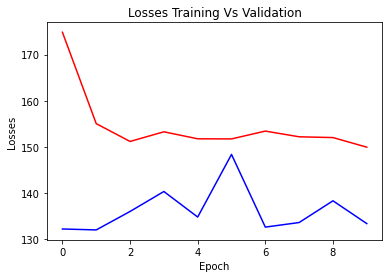

In [163]:
import matplotlib.pyplot as plt

plt.title('Losses Training Vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.plot(training_losses_history, '-r')
plt.plot(validation_losses_history, '-b')

Plot the accuracy graph

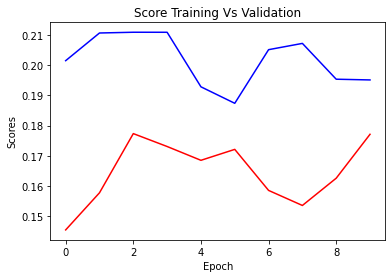

In [164]:
plt.title('Score Training Vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Scores')
plt.plot(training_score_history, '-r')
plt.plot(validation_score_history, '-b')

Function to predict for the test data

In [165]:
def predections(dataloader):
  test_tm_predictions = []
  net.eval()
  with torch.no_grad():
    for img in dataloader:
      img = img.to(DEVICE)
      tm_prediction = net(img)
      test_tm_predictions.append(tm_prediction.cpu().numpy())
  return [tm.squeeze().tolist() for tm in test_tm_predictions]

In [166]:
tm = predections(test_loader)

Create a Dataframe with seq id and tm prediction

In [167]:
df = pd.DataFrame({"seq_id":test_seq_id, "tm":tm })
df

,seq_id,tm
0,31390,55.642227
1,31391,55.639450
2,31392,56.957088
3,31393,55.628628
4,31394,55.639275
...,...,...
2408,33798,56.002319
2409,33799,56.002319
2410,33800,56.006866
2411,33801,55.889465


In [168]:
df.describe()[['tm']].transpose()

,count,mean,std,min,25%,50%,75%,max
tm,2413.0,55.585655,0.699981,50.237091,55.57811,55.634674,55.682705,61.56295


convert dataframe into csv file

In [169]:
df.to_csv("submission.csv", index=False)